<a href="https://colab.research.google.com/github/Nisjain120/Projects/blob/main/Nischay_Jain_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KMeans with k=2 - DB Index: 1.5731, Silhouette Score: 0.2405
KMeans with k=3 - DB Index: 1.4100, Silhouette Score: 0.2192
KMeans with k=4 - DB Index: 1.5666, Silhouette Score: 0.1754
KMeans with k=5 - DB Index: 1.5344, Silhouette Score: 0.1890
KMeans with k=6 - DB Index: 1.4004, Silhouette Score: 0.1888
KMeans with k=7 - DB Index: 1.4101, Silhouette Score: 0.1815
KMeans with k=8 - DB Index: 1.3720, Silhouette Score: 0.1804
KMeans with k=9 - DB Index: 1.4169, Silhouette Score: 0.1757
KMeans with k=10 - DB Index: 1.3322, Silhouette Score: 0.1899
Agglomerative with k=2 - DB Index: 1.8536, Silhouette Score: 0.1649
Agglomerative with k=3 - DB Index: 1.6040, Silhouette Score: 0.1460
Agglomerative with k=4 - DB Index: 1.6560, Silhouette Score: 0.1396
Agglomerative with k=5 - DB Index: 1.6529, Silhouette Score: 0.1269
Agglomerative with k=6 - DB Index: 1.6169, Silhouette Score: 0.1373
Agglomerative with k=7 - DB Index: 1.5245, Silhouette Score: 0.1433
Agglomerative with k=8 - DB Index: 1.5053,

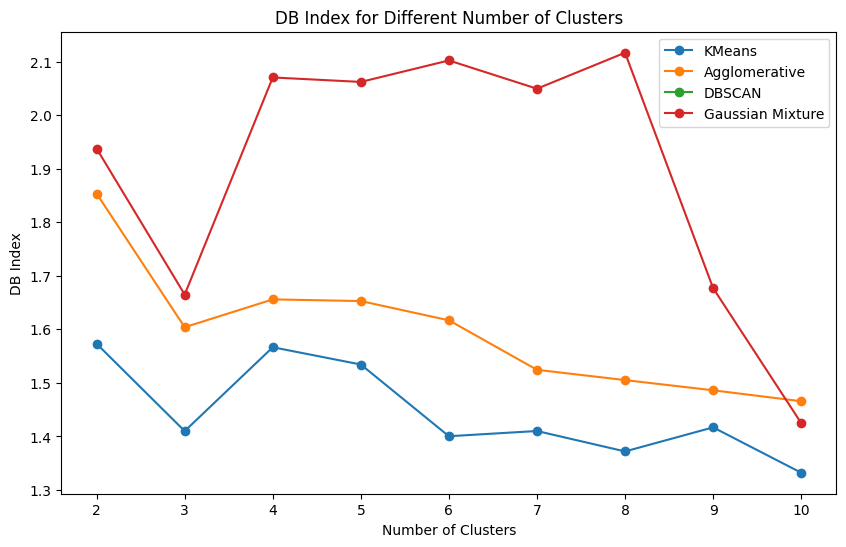

Best clustering model based on DB Index: KMeans with k=10


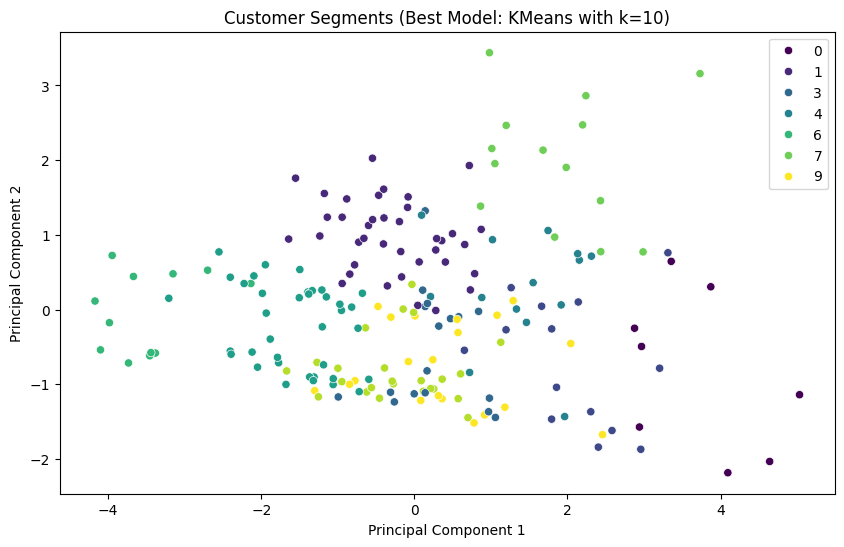

  CustomerID  total_spend  num_transactions last_transaction_date  \
0      C0001      3354.52                 5   2024-11-02 17:04:16   
1      C0002      1862.74                 4   2024-12-03 01:41:41   
2      C0003      2725.38                 4   2024-08-24 18:54:04   
3      C0004      5354.88                 8   2024-12-23 14:13:52   
4      C0005      2034.24                 3   2024-11-04 00:30:22   

         regions  recency  Books  Clothing  Electronics  Home Decor  Cluster  
0  South America       81    2.0       0.0          7.0         3.0        9  
1           Asia       50    0.0       4.0          0.0         6.0        1  
2  South America      151    0.0       4.0          4.0         6.0        1  
3  South America       30    8.0       0.0          6.0         9.0        7  
4           Asia       79    0.0       0.0          4.0         3.0        5  


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

customers_df = pd.read_csv("/content/Customers.csv")
transactions_df = pd.read_csv('/content/Transactions.csv')
products_df = pd.read_csv('/content/Products.csv')

customer_transactions = transactions_df.merge(customers_df[['CustomerID', 'Region']], on='CustomerID', how='left')
customer_transactions = customer_transactions.merge(products_df[['ProductID', 'Category']], on='ProductID', how='left')

customer_summary = customer_transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'nunique'),
    last_transaction_date=('TransactionDate', 'max'),
    regions=('Region', 'first')
).reset_index()

customer_summary['last_transaction_date'] = pd.to_datetime(customer_summary['last_transaction_date'])
customer_summary['recency'] = (pd.to_datetime('today') - customer_summary['last_transaction_date']).dt.days

category_summary = customer_transactions.groupby(['CustomerID', 'Category']).agg(
    total_quantity=('Quantity', 'sum')
).unstack().fillna(0)

category_summary.columns = [col[1] for col in category_summary.columns]

customer_profile = customer_summary.merge(category_summary, on='CustomerID', how='left')

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile.drop(['CustomerID', 'regions', 'last_transaction_date'], axis=1))

clustering_models = {
    "KMeans": KMeans(random_state=42),
    "Agglomerative": AgglomerativeClustering(),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "Gaussian Mixture": GaussianMixture(random_state=42)
}

db_indexes = {}
silhouette_scores = {}

for name, model in clustering_models.items():
    for k in range(2, 11):
        if name in ["KMeans", "Agglomerative", "Gaussian Mixture"]:
            if name == "KMeans":
                model.set_params(n_clusters=k)
            elif name == "Agglomerative":
                model.set_params(n_clusters=k)
            elif name == "Gaussian Mixture":
                model.set_params(n_components=k)
            labels = model.fit_predict(scaled_features)
        else:
            labels = model.fit_predict(scaled_features)

        if len(np.unique(labels)) > 1:
            db_indexes[(name, k)] = davies_bouldin_score(scaled_features, labels)
            silhouette_scores[(name, k)] = silhouette_score(scaled_features, labels)
            print(f"{name} with k={k} - DB Index: {db_indexes[(name, k)]:.4f}, Silhouette Score: {silhouette_scores[(name, k)]:.4f}")
        else:
            print(f"{name} with k={k} - Only 1 cluster formed, skipping DB Index and Silhouette Score")

plt.figure(figsize=(10, 6))
for name in clustering_models:
    db_index_values = [db_indexes.get((name, k), np.nan) for k in range(2, 11)]
    plt.plot(range(2, 11), db_index_values, marker='o', label=name)

plt.title('DB Index for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.legend()
plt.show()

best_db_index_model = min(db_indexes, key=db_indexes.get) if db_indexes else None
if best_db_index_model:
    best_model_name, best_k = best_db_index_model
    print(f"Best clustering model based on DB Index: {best_model_name} with k={best_k}")

    best_model = clustering_models[best_model_name]

    if best_model_name == "KMeans":
        best_model.set_params(n_clusters=best_k)
    elif best_model_name == "Agglomerative":
        best_model.set_params(n_clusters=best_k)
    elif best_model_name == "Gaussian Mixture":
        best_model.set_params(n_components=best_k)
    else:
        best_labels = best_model.fit_predict(scaled_features)

    best_labels = best_model.fit_predict(scaled_features)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=best_labels, palette='viridis')
    plt.title(f'Customer Segments (Best Model: {best_model_name} with k={best_k})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    customer_profile['Cluster'] = best_labels
    customer_profile.to_csv('Customer_Segments_Comparison.csv', index=False)

    print(customer_profile.head())
else:
    print("No valid clustering model with more than 1 cluster was found.")
